In [1]:
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import pipeline, arima, model_selection
from sklearn.metrics import mean_squared_error
import pandas as pd
import pickle
from tqdm import tqdm
from darts import TimeSeries

Provided Code to Load Data

In [2]:
# Load the data
price_path = os.path.join(os.getcwd(),'elspotprices_19to21.csv')
df_prices = pd.read_csv(price_path)
df_prices['HourUTC'] = pd.to_datetime(df_prices["HourUTC"])
# Remove timezone information
df_prices["HourUTC"] = df_prices["HourUTC"].dt.tz_localize(None)
# Sort values
df_prices = df_prices.sort_values('HourUTC')
df_prices = df_prices.reset_index(drop=True)
# Load the data
Exog_path = os.path.join(os.getcwd(),'production_19to21.csv')
df_exog = pd.read_csv(Exog_path)
df_exog['HourUTC'] = pd.to_datetime(df_exog["HourUTC"])
# Sort values
df_exog = df_exog.sort_values('HourUTC')
df_exog = df_exog.reset_index(drop=True)

### Changing Dataset
Remove HourDK, SpotPriceEUR, and choose DK1 as the region of interest

In [3]:
df_prices = df_prices.loc[df_prices["PriceArea"] == 'DK1']
df_prices = df_prices.drop(columns=['HourDK','SpotPriceEUR'])
df_prices = df_prices.reset_index(drop=True)

df_exog = df_exog.loc[df_exog["PriceArea"] == 'DK1']
df_exog = df_exog.drop(columns=['HourDK'])
df_exog = df_exog.reset_index(drop=True)

Reduce df_prices & df_exog size to only have only data from the date specified onwards

In [4]:
start_train_date = '2021-08-30T23:00:00.000'

df_prices_start_date = np.min(df_prices.index[df_prices['HourUTC'] == start_train_date])
df_prices = df_prices[df_prices_start_date:]
df_prices = df_prices.reset_index(drop=True)

df_exog_start_date = np.min(df_exog.index[df_exog['HourUTC'] == start_train_date])
df_exog = df_exog[df_exog_start_date:]
df_exog = df_exog.reset_index(drop=True)

#### Training and Testing Datasets
Seperate test data and training data

In [5]:

#get index of the given end training set date
end_training_set_date = '2021-12-01T00:00:00.000'
set_train_size = np.max(df_prices.index[df_prices['HourUTC'] == end_training_set_date])

train, test = model_selection.train_test_split(df_prices, train_size=set_train_size)
X_train, X_test = model_selection.train_test_split(df_exog, train_size=set_train_size)

train = train["SpotPriceDKK"].values
test = test["SpotPriceDKK"].values
data = df_prices['SpotPriceDKK'].values

n_train = len(train)
n_test = len(test)
n_data = len(data)

## Task 1
Develop an ARIMA model to predict electricity prices. Your goal in all following tasks is to
achieve the best possible performance. In all sub-tasks, report the RMSE values you achieve
with your models. Pick a zone (DK1 or DK2) of your liking

### Task 1.1
Use NO exogenous variables in your model and make hour-ahead and day-ahead prediction
for your testing dataset. You can use a seasonal ARIMA or FourierFeaturizer and any data
transformation you want in your model, but no features from the production 19to21 dataset.
Establish a suitable persistence forecast, and report the RMSE values in all 4 cases (your model
and persistence, and for both hour-ahead and day-ahead). Briefly discuss your results and the
difference between the two forecasting cases.

## Hour Models

Persistence Model

In [ ]:
time_length = 1

Persistence_hour = []

time_estimate_frames = int(len(test)/time_length)

for i in range(time_estimate_frames):

    spliced_estiamte_frame = data[len(train)+i*time_length-time_length:len(train)+(i+1)*time_length-time_length]
    Persistence_hour.extend(spliced_estiamte_frame)

RMSE_P_H = mean_squared_error(Persistence_hour, test)

ARIMA Model

In [ ]:
time_length = 1

ARIMA_Forecast_H = []

time_estimate_frames = int(len(test)/time_length)

#m is set to 24 due to the seasonal affect of the 24 hour energy cycle
ARIMA = pm.auto_arima(train, trace = True, seasonal=True, iter = 100)

for i in tqdm(range(time_estimate_frames)):
    time_step_forcast = ARIMA.predict(n_periods = time_length)

    ARIMA_Forecast_H.extend(time_step_forcast)

    ARIMA.update(test[i])

RMSE_A_H = mean_squared_error(ARIMA_Forecast_H, test)

Save model and forcasted values to a pickel so I dont have to run it again.

In [ ]:
filename = "arima_hour_seasonal"
model_dic = {'model': ARIMA, 'forcasted_values': ARIMA_Forecast_H}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Alternate Fourier Hour

In [ ]:
time_length = 1
time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    forecast= pipe.predict(n_periods=time_length)
    
    pipe.update(test[i*time_length:(i+1)*time_length])
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

RMSE_F_H = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_hour_m168_k24_"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

## Day Models

Persistence Model

In [ ]:
persistence_time_length = 24

Persistence_day = []

time_estimate_frames = int(len(test)/persistence_time_length)

for i in range(time_estimate_frames):

    spliced_estiamte_frame = data[len(train)+i*persistence_time_length-persistence_time_length:len(train)+(i+1)
    *persistence_time_length-persistence_time_length]
    
    Persistence_day.extend(spliced_estiamte_frame)

RMSE_P_D = mean_squared_error(Persistence_day, test)

ARIMA Model

In [ ]:
time_length = 24

ARIMA_Forecast_D = []

time_estimate_frames = int(len(test)/time_length)

#m is set to 24* due to the seasonal affect of the 24*7 hour energy cycle
ARIMA = pm.auto_arima(train, trace = True, seasonal=True, iter = 100)

for i in tqdm(range(time_estimate_frames)):
    
    time_step_forcast = ARIMA.predict(n_periods = time_length)

    ARIMA_Forecast_D.extend(time_step_forcast)

    ARIMA.update(test[i*time_length:(i+1)*time_length])

RMSE_A_D = mean_squared_error(ARIMA_Forecast_D, test)

In [ ]:
filename = "arima_day_seasonal"
model_dic = {'model': ARIMA, 'forcasted_values': ARIMA_Forecast_D}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Alternate Fourier Model

In [ ]:
time_length = 24
time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    forecast= pipe.predict(n_periods=time_length)
    
    pipe.update(test[i*time_length:(i+1)*time_length])
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

RMSE_F_D = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_day_m168_k24_"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Report the RMSE values in all 4 cases (your model
and persistence, and for both hour-ahead and day-ahead). Briefly discuss your results and the
difference between the two forecasting cases.

In [ ]:
fourier_hour = 'fourier_hour_m168_k24_'
#fourier_hour_exog = 'fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh'
fourier_day = 'fourier_day_m168_k24_'
#fourier_day_exog = 'fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest'

model_list = ['fourier_hour_m168_k24_','fourier_day_m168_k24_']

RMSE_list = {}

for model in model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list[model] = mean_squared_error(forcasted_values, test)

RMSE_list['Persistence_Day'] = mean_squared_error(Persistence_day,test)
RMSE_list['Persistence_Hour'] = mean_squared_error(Persistence_hour,test)

RMSE_list = np.transpose(np.array([list(RMSE_list.keys()),list(RMSE_list.values())]))

print(RMSE_list)


### Task 1.2
Add any exogenous variables you want (maximum 3) and repeat the process (choose/optimize your
model and evaluate it for the hour-ahead and the day-ahead prediction). What exogenous
variables helped you improve the prediction and how did you choose the specific ones? Compare
your results with those from task 1.1 and briefly discuss them.

In [6]:
df_exog['SpotPriceDKK'] = df_prices['SpotPriceDKK']
correlate = df_exog.iloc[:,3:].corr()

X_train = X_train[["ExchangeSE_MWh", "OffshoreWindGe100MW_MWh","PowerToHeatMWh"]].values
X_test = X_test[["ExchangeSE_MWh", "OffshoreWindGe100MW_MWh","PowerToHeatMWh"]].values

n_X_train = len(X_train)
n_X_test = len(X_test)

X_train_ar = np.column_stack([np.arange(1,n_X_train+1),X_train])

# The following 2 code blocks are only there to look at evaluting which exog variables to use

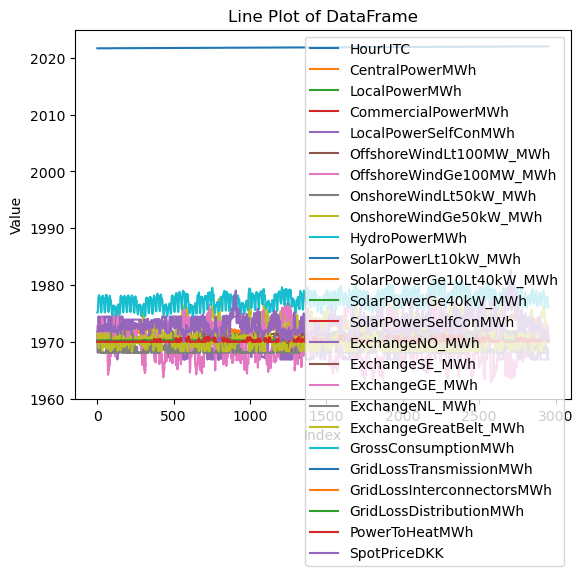

In [7]:
fig, ax = plt.subplots()

# plot each column of the DataFrame as a line
df_exog.plot(ax=ax)

# set the x and y axis labels
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# set the title of the plot
ax.set_title('Line Plot of DataFrame')

# show the plot
plt.show()

In [ ]:
#df_exog = df_exog.drop('PriceArea', axis = 1)
record = {}
for column in df_exog:
    current = np.correlate(df_exog[column], df_prices['SpotPriceDKK'])
    record[column] = [current]

record = np.transpose(np.array([list(record.keys()),list(record.values())]))

Hour Ahead Prediction

In [ ]:
time_length = 1

time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train, X = X_train_ar)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    X_f = np.column_stack([np.arange(1, time_length+1), X_test[i*time_length:(i+1)*time_length]])

    forecast = pipe.predict(n_periods=time_length, X=X_f)
    
    pipe.update(test[i*time_length:(i+1)*time_length], X = X_f)
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

#Do I need this line? Not sure
rolling_forecast = [0 if x < 0 else x for x in rolling_forecast]

RMSE_F_H = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Day Ahead Prediction

In [ ]:
time_length = 24

time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train, X = X_train_ar)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    X_f = np.column_stack([np.arange(1, time_length+1), X_test[i*time_length:(i+1)*time_length]])

    forecast= pipe.predict(n_periods=time_length, X=X_f)
    
    pipe.update(test[i*time_length:(i+1)*time_length], X=X_f)
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

rolling_forecast = [0 if x < 0 else x for x in rolling_forecast]

RMSE_F_D = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWh"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'test.pkl','wb') as f:
    pickle.dump(model_dic,f)

The following code opens and adds all the model errors so they can be comapared, the persitence day and hour models need to be ran in order to run this block

In [28]:
fourier_hour = 'fourier_hour_m168_k24_'
fourier_hour_exog = 'fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh'
fourier_day = 'fourier_day_m168_k24_'
fourier_day_exog = 'fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest'

day_model_list = ['fourier_day_m168_k24_','fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest']

hour_model_list = ['fourier_hour_m168_k24_','fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh']

RMSE_list = []

for model in day_model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list.append(["Day", model, mean_squared_error(forcasted_values, test)])

RMSE_list.append(["Day", 'Persistence_Day',mean_squared_error(Persistence_day,test)])

for model in hour_model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list.append(["Hour", model, mean_squared_error(forcasted_values, test)])

RMSE_list.append(["Hour", 'Persistence_Hour', mean_squared_error(Persistence_hour,test)])

print(RMSE_list)


NameError: name 'Persistence_day' is not defined

# Task 2
Develop a temporal Convolutional Neural Network (tCNN) to predict the electricity prices.
Your goal in all following tasks is to achieve an as good performance as possible.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime as dt

from darts.timeseries import TimeSeries as DTS
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.metrics import mape, mae, mse, rmse
from darts import concatenate

Create a new dataframe for all network data and specifiy the features (exog variables & time) and target (SpotPrice)

In [16]:
#remove duplicate label
#df_exog = df_exog.drop(["HourUTC"], axis=1)

df_network = pd.concat([df_prices, df_exog], axis = 1)
# Remove timezone
df_network['HourUTC'] = df_network['HourUTC'].dt.tz_localize(None)
# Set HourUTC as index
df_network.set_index('HourUTC', inplace = True)
df_network = df_network.sort_index()

features = ["ExchangeSE_MWh","OffshoreWindGe100MW_MWh","PowerToHeatMWh"]
targets = ["SpotPriceDKK"]

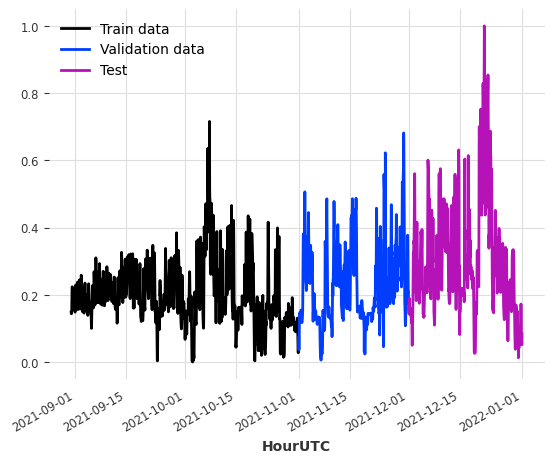

In [21]:
series_load = DTS.from_dataframe(df_network[targets])
series_weather = DTS.from_dataframe(df_network[features])

# series_price=DTS.from_dataframe(df_prices) # For Assignment


# Date for Train Test Split 
trainval_testsplit = "20211201" # data will be split after  
trainval_testsplit = pd.to_datetime(dt.datetime(2021, 12, 1))
#transforming data
# For more info : https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html
scaler = Scaler()
series_load_transformed = scaler.fit_transform(series_load)
scaler_cov = Scaler()
series_weather_transformed = scaler_cov.fit_transform(series_weather)

# Try
# print(max(series_load.values()))
# print(max(series_load_transformed.values()))

#Dividing into test and training set
train_val_load_transformed, test_load_transformed = series_load_transformed.split_after(
    pd.Timestamp(trainval_testsplit)
)

# Training set is further divided into training and validation
train_valsplit = "20211101" # data will be split to validation set after 
train_valsplit = pd.to_datetime(dt.datetime(2021, 11, 1))

train_load_transformed, val_load_transformed = train_val_load_transformed.split_after(
    pd.Timestamp(train_valsplit)
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_load_transformed, attribute="hour" , one_hot=True
)


scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)

#Combining exogenous variable with day
#allCov = day_series.stack(series_PV_transformed)
allCov = concatenate([day_series, series_weather_transformed], axis=1)
# For more information : https://unit8co.github.io/darts/userguide/covariates.html

train_load_transformed.plot(label="Train data")
val_load_transformed.plot(label="Validation data")
test_load_transformed.plot(label="Test")

In [22]:
#For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html
model_en = TCNModel(
    input_chunk_length=72, # Try testing different values eg 120
    output_chunk_length=24,
    n_epochs=5, # 50 epochs will take 15-20 min; default is 100 epochs
    dropout=0.1,
    dilation_base=2, # Try other values. Preferably below the kernal size
    weight_norm=True,
    kernel_size=3, #Try updating this value for eg try 8
    num_filters=4, #Try updating this value for eg try 20
    nr_epochs_val_period=1, 
    random_state=0,
)

In [23]:
model_en.fit(
    series=train_load_transformed,
    past_covariates=allCov,
    val_series=val_load_transformed,
    val_past_covariates=allCov,
    verbose=False,    
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
#For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html#darts.models.forecasting.tcn_model.TCNModel.backtest
backtest_start_date = pd.to_datetime('20211001')
backtest_en = model_en.historical_forecasts(
    series=series_load_transformed,
    past_covariates=allCov,
    start=backtest_start_date,
    forecast_horizon=24,
    stride=1,
    retrain=False,
    verbose=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MAE = 0.1057
MAPE = 79.60%
RMSE = 0.1502
MSE = 0.0226


Predicting: 0it [00:00, ?it/s]

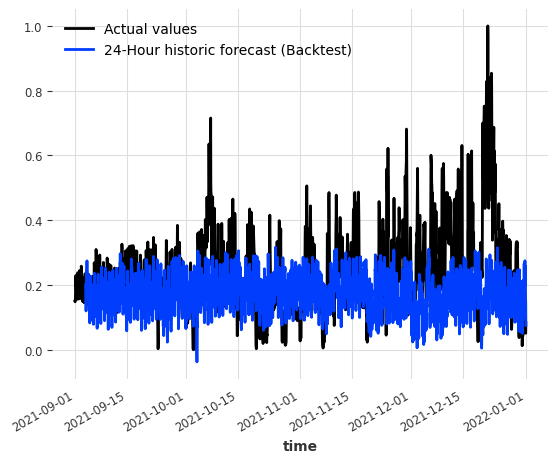

In [27]:
series_load_transformed[backtest_start_date:].plot(label="Actual values")
backtest_en.plot(label="24-Hour historic forecast (Backtest)")
plt.legend()

print("MAE = {:.4f}".format(mae(backtest_en, series_load_transformed)))
print("MAPE = {:.2f}%".format(mape(backtest_en, series_load_transformed)))
print("RMSE = {:.4f}".format(rmse(backtest_en, series_load_transformed)))
print("MSE = {:.4f}".format(mse(backtest_en, series_load_transformed)))

#  After tunning the hyper parameters test the model
prediction_transformed = model_en.predict(48, series=train_val_load_transformed, past_covariates=allCov)
prediction=scaler.inverse_transform(prediction_transformed).pd_dataframe()